There we import tensorflow pre-trained models. Inception v4 and v2 are also available if needed

In [15]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets as nets

import tempfile
from urllib.request import urlretrieve
import tarfile
import os

import json
import matplotlib.pyplot as plt

import PIL
import numpy as np

There we establish session for the whole notebook. On what is session and why tf.* code is not executed when you expect it to be read this article:

https://www.easy-tensorflow.com/tf-tutorials/basics/graph-and-session

In [2]:
tf.logging.set_verbosity(tf.logging.ERROR)
sess = tf.InteractiveSession()

There we declare `f.Variable`for our adversarial image. This type is used for all dynamically changing obects (such as weights of the model). Note that `f.Variable`actually does not store the value inside it, rather it stores *operations* allowing to get this value. To actually *init* `f.Variable` run `tf.global_varibles_initializer`. Remember that the size of the `tf.Variable` cannot be changed dinamically in the code. One can change its dimensionality, though. More about `tf.Variables` and the difference between them, `tf.constant` and `tf.placeholder` can be found here:

https://www.easy-tensorflow.com/tf-tutorials/basics/graph-and-session

In [3]:
image = tf.Variable(tf.zeros((299, 299, 3)))

# code to print image as an array
# sess.run(tf.global_variables_initializer())
# print(image.eval())

tf.expand_dims(tf.Variable, axis=?) is equivalent to np.reshape(np.ndarray), but only adds one dimesion and numeration of axis is from the left to the right. Arg_scope downloads default parameters of the model (such as size of convolutional regions). 

In [4]:
def inception(image, reuse):
    preprocessed = tf.multiply(tf.subtract(tf.expand_dims(image, 0), 0.5), 2.0)
    arg_scope = nets.inception.inception_v3_arg_scope(weight_decay=0.0)
    with slim.arg_scope(arg_scope):
        logits, _ = nets.inception.inception_v3(
            preprocessed, 1001, is_training=False, reuse=reuse)
        logits = logits[:,1:] # ignore background class
        probs = tf.nn.softmax(logits) # probabilities
    return logits, probs

logits, probs = inception(image, reuse=False)

Download pretrained weights. Remember, that mkdtemp() just creates dir and returns its path, and if you do not explicitly delete this file later it will remain.

In [5]:
data_dir = tempfile.mkdtemp()
inception_tarball, _ = urlretrieve(
    'http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz')
tarfile.open(inception_tarball, 'r:gz').extractall(data_dir)

In [6]:
print(data_dir)

/tmp/tmp74vrsyrv


This function loads weights for inception_v3 model.

In [7]:
restore_vars = [
    var for var in tf.global_variables()
    if var.name.startswith('InceptionV3/')
]
saver = tf.train.Saver(restore_vars)
saver.restore(sess, os.path.join(data_dir, 'inception_v3.ckpt'))

This snippet downloads json file with labels for imagenet images.

In [9]:
imagenet_json, _ = urlretrieve(
    'http://www.anishathalye.com/media/2017/07/25/imagenet.json')
with open(imagenet_json) as f:
    imagenet_labels = json.load(f)

In [12]:
# print (imagenet_labels)

The following cells have functions allowing to manipulate with the image. Note that `image.open()` function needs local addresses to work. Also remember, that function `Image.paste(region)` applies squared patch to certain coordinates, and if the size of the patch does not match the size of the region, it will break.  For more information on Pillow library, see

https://pillow.readthedocs.io/en/latest/

Also note, that pillow package provides an efficient way to rotate, crop part of the image way to 

In [22]:
def show_image(img):
    imgplot = plt.imshow(img)
    plt.show()

In [14]:
def classify_image(img, correct_class=None, target_class=None):
    pass

In [13]:
def classify(img, correct_class=None, target_class=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
    fig.sca(ax1)
    p = sess.run(probs, feed_dict={image: img})[0]
    ax1.imshow(img)
    fig.sca(ax1)
    
    topk = list(p.argsort()[-10:][::-1])
    topprobs = p[topk]
    barlist = ax2.bar(range(10), topprobs)
    if target_class in topk:
        barlist[topk.index(target_class)].set_color('r')
    if correct_class in topk:
        barlist[topk.index(correct_class)].set_color('g')
    plt.sca(ax2)
    plt.ylim([0, 1.1])
    plt.xticks(range(10),
               [imagenet_labels[i][:15] for i in topk],
               rotation='vertical')
    fig.subplots_adjust(bottom=0.2)
    plt.show()

Examples showing work of image library are shown below.

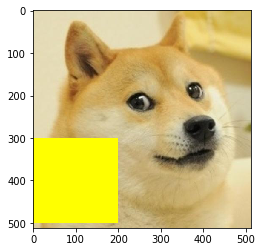

In [53]:
# choose an image to play with
img1_path, _ = urlretrieve('https://farm1.static.flickr.com/227/467863966_a01cbd9d90.jpg')
img2_path = './ImageNet/467863966_a01cbd9d90.jpg'
img3_path = './ImageNet/857502810_4313e2fbd4.jpg'
img4_path = './ImageNet/81-yKbVND-L.png'
img5_path = './ImageNet/81-yKbVND-L.jpg'

# load image in memory and get img
my_img = PIL.Image.open(img5_path)

# rotation example
#my_img = my_img.rotate(45)

# cropping example
#box = (100, 100, 400, 400)
#my_img = my_img.crop(box)

# patching example
patch_location = (0, 300)
patch_size = (200, 200)
patch = PIL.Image.new("RGB", patch_size, color=(255, 255, 0))
my_img.paste(patch, (patch_location[0], patch_location[1], patch_location[0] + patch_size[0], 
                     patch_location[1] + patch_size[1]))

show_image(my_img)


Let's show how classification works

In [42]:
img_path, _ = urlretrieve('https://farm1.static.flickr.com/227/467863966_a01cbd9d90.jpg')
img_path = img5_path
img_class = 281
img = PIL.Image.open(img_path)
big_dim = max(img.width, img.height)
wide = img.width > img.height
new_w = 299 if not wide else int(img.width * 299 / img.height)
new_h = 299 if wide else int(img.height * 299 / img.width)
img = img.resize((new_w, new_h)).crop((0, 0, 299, 299))
img = (np.asarray(img) / 255.0).astype(np.float32)

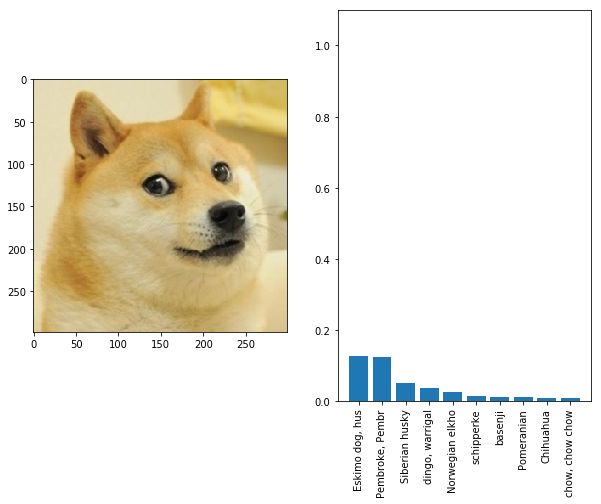

In [43]:
classify(img)

In [55]:
x = tf.placeholder(tf.float32, (299, 299, 3))

x_hat = image # our trainable adversarial input
assign_op = tf.assign(x_hat, x)

In [56]:
learning_rate = tf.placeholder(tf.float32, ())
y_hat = tf.placeholder(tf.int32, ())

labels = tf.one_hot(y_hat, 1000)
loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=[labels])
optim_step = tf.train.GradientDescentOptimizer(
    learning_rate).minimize(loss, var_list=[x_hat])

In [57]:
epsilon = tf.placeholder(tf.float32, ())

below = x - epsilon
above = x + epsilon
projected = tf.clip_by_value(tf.clip_by_value(x_hat, below, above), 0, 1)
with tf.control_dependencies([projected]):
    project_step = tf.assign(x_hat, projected)

In [58]:
demo_epsilon = 2.0/255.0 # a really small perturbation
demo_lr = 1e-1
demo_steps = 100
demo_target = 924 # "guacamole"

# initialization step
sess.run(assign_op, feed_dict={x: img})

# projected gradient descent
for i in range(demo_steps):
    # gradient descent step
    _, loss_value = sess.run(
        [optim_step, loss],
        feed_dict={learning_rate: demo_lr, y_hat: demo_target})
    # project step
    sess.run(project_step, feed_dict={x: img, epsilon: demo_epsilon})
    if (i+1) % 10 == 0:
        print('step %d, loss=%g' % (i+1, loss_value))
    

adv = x_hat.eval() # retrieve the adversarial example

step 10, loss=2.80116
step 20, loss=0.00104182
step 30, loss=0.000728342
step 40, loss=0.000602541
step 50, loss=0.000523192
step 60, loss=0.000468502
step 70, loss=0.000427155
step 80, loss=0.000393552
step 90, loss=0.000368051
step 100, loss=0.000346124


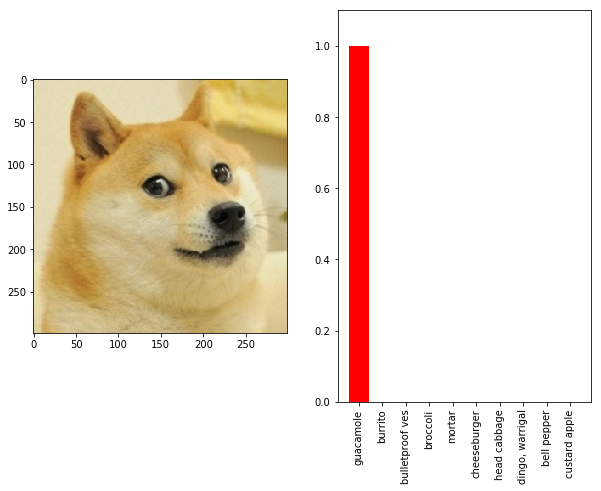

In [59]:
classify(adv, target_class=demo_target)